## Multi-Objective Optimization
Version 0.0.2
(c) Larry Lueer, Vincent LeCorre, i-MEET 2021-2022

In [1]:
# necessary imports

#%matplotlib notebook # switch this on when on JupyterHub
#%matplotlib inline

#from imeet import * # old packages
import sys
#sys.path.append('/home/larryl/Desktop/PVLC_notebook') 
sys.path.append('/home/larryl/Documents/PVLC_notebook')
sys.path.append('/home/larryl/Documents/vscodeprojs/boar')
from boar import * # new package
import pandas as pd
from numpy.random import default_rng

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel, WhiteKernel)



In [2]:
# **************** MODEL FUNCTION ***********

def model(X, params):
    """Model function to be used by the optimizer

    Args:
        x (ndarray): [description]
        params (list): function coefficients as provided by the optimizer
    Returns:
        y (ndarray)
    """

    a = [pp.val for pp in params if pp.name=='a'][0] # find Fitparam named 'a'
    b = [pp.val for pp in params if pp.name=='b'][0] # find Fitparam named 'b'
    c = [pp.val for pp in params if pp.name=='c'][0] # find Fitparam named 'b'
    #d = [pp.val for pp in params if pp.name=='d'][0] # find Fitparam named 'b'
    b1 = b*X[:,1] # b1 depends only on temperature    # !!!!!!!!!!!!!!!!!!!!! RRRRREMOVE THE ZERO!!!!!!!!!!!!
    y = (a+b1+c)*X[:,0]#+c+d # therefore the linear slope along X[:,0] depends on temperature
    #y = (a+b1)*X[:,0]#+c+d # therefore the linear slope along X[:,0] depends on temperature. This version is independent of c
    return y

In [3]:
# define Fitparameters
a = Fitparam(name = 'a',val=5,relRange=0.5,lims=[],
    range_type='linear',lim_type='relative',optim_type='linear')
b = Fitparam(name = 'b',val=5,relRange=0.5,lims=[],
    range_type='linear',lim_type='relative',optim_type='linear')
c = Fitparam(name = 'c',val=1,relRange=0.5,lims=[],
    range_type='linear',lim_type='relative',optim_type='linear')
d = Fitparam(name = 'd',val=1,relRange=1,lims=[],
    range_type='log',lim_type='relative',optim_type='log')
params = [a,b,c]

In [4]:
# create some fake data

outliers = False 
systematic_deviations = False
thr = 100 # threshold for onset of nonlinear behavior (only for systematic_deviations)


dimensions = ['time', 'intensity']
t  = np.linspace(0,10,101)
#L = np.linspace(0.1,10,1)
L = [0.1,0.5] 
X = np.array([[x,y] for x in L for y in t])
X = np.fliplr(X)
y = model(X,params)
rng = default_rng()#
noise = rng.standard_normal(y.shape) * 1
#noise = noise * X[:,1] # try this: higher T - higher noise  
y+=noise # add some noise
#y[y>0] = y[y>0]**1.2 # add some spurious non-linearlity (can be handled using weights)

if outliers:
    for ii in range(len(t)*len(L))[::50]:
        y[ii] = 100 # produce a periodic artifact ( can be handled using loss functions)
if systematic_deviations:
    y = thr*(np.exp(y/thr)-1)



In [5]:
# create target & start MO

#provide a wrong startVal to make it a bit harder for the optimizer

a.startVal = 5
b.startVal = 5
use_weighting = False
thrw = 1

if use_weighting:
    weight = 1/((np.abs(y)+1e-15))**2
    weight[weight>thrw]=thrw
else:
    weight =1

target = {'model':model,'data':{'X':X,'y':y, 'X_dimensions':['time','T'],
                                'X_units':['s','ºC'],'y_dimension':'Current density',
                                'y_unit':r'$mA/cm²$'},
            'params':params, 'weight':weight}
mo = MultiObjectiveOptimizer(targets = [target])

# First, use a gradient based optimizer
kwargs = {'ftol':1e-8, 'xtol':1e-6, 'gtol': 1e-8, 'diff_step':0.001,
                         'loss':'linear','max_nfev':5000}
r = mo.optimize_curvefit(kwargs=kwargs) # use a gradient based optimizer


popt [4.95948889 5.09016746 0.99189779]
pcov [[ 8.44925112e+20 -5.20827301e+08 -8.44925112e+20]
 [-5.20827301e+08  4.02417763e-03  5.20827301e+08]
 [-8.44925112e+20  5.20827301e+08  8.44925112e+20]]
std [2.90675956e+10 6.34364062e-02 2.90675956e+10]


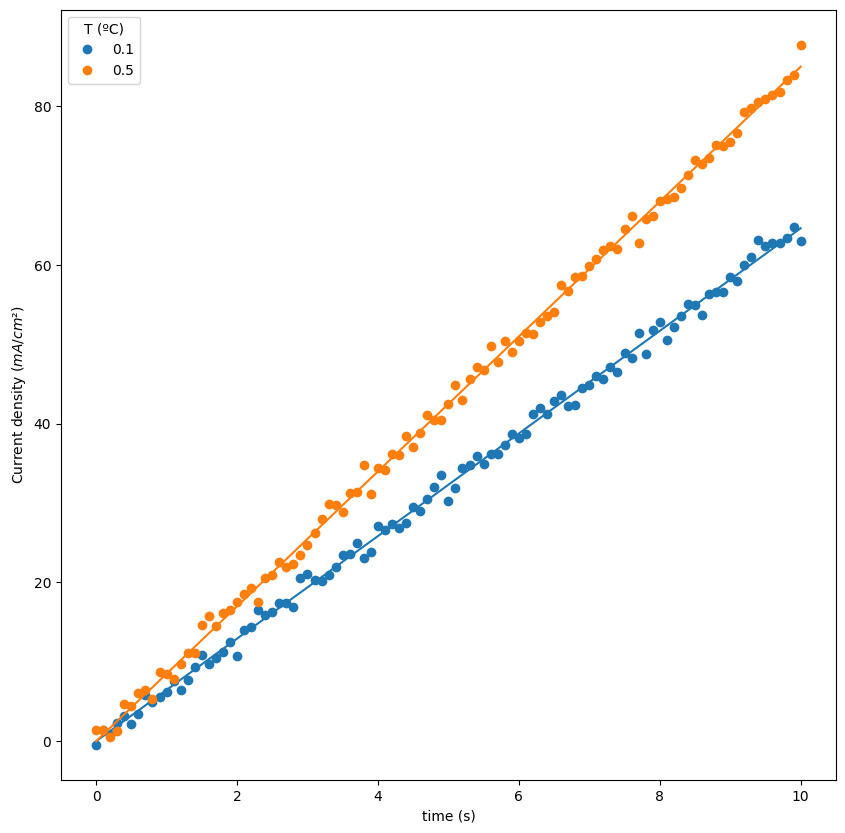

In [6]:
# plot the result from the gradient based optimzer
popt = r['popt']
std = np.sqrt(np.diag(r['pcov']))
yfit = model(X,params)

print('popt',r['popt'])
print('pcov',r['pcov'])
print('std',std)

x_dims = target['data']['X_dimensions']   
x_units = target['data']['X_units'] 
y_dim = target['data']['y_dimension']  
y_unit = target['data']['y_unit']    

xnames = [x_dim + f' ({x_unit})' for x_dim,x_unit in zip(x_dims,x_units)]
yname = y_dim + f' ({y_unit})'
plt.figure(figsize=(10,10))
for ii,L0 in enumerate(L): 
    pick = X[:,1]==L0
    xp = X[pick,0]
    yp = y[pick]
    plt.plot(xp,yp,'o',c='C'+str(ii),label=L0)
    yf = yfit[pick]
    plt.plot(xp,yf,c='C'+str(ii))
plt.xlabel(xnames[0])
plt.ylabel(yname)
plt.legend(title=xnames[1])


finding scaling factor for y


Scaling runs for target 0:   0%|          | 0/5 [00:00<?, ?it/s]

/home/larryl/Documents/vscodeprojs/boar/boar/core/optimization.py:1152: UserWarning: target_weight for target 0 must be a float or int. Using default value of 1.
  warnings.warn('target_weight for target '+str(num)+' must be a float or int. Using default value of 1.')
/home/larryl/Documents/vscodeprojs/boar/boar/core/optimization.py:1152: UserWarning: target_weight for target 0 must be a float or int. Using default value of 1.
  warnings.warn('target_weight for target '+str(num)+' must be a float or int. Using default value of 1.')
/home/larryl/Documents/vscodeprojs/boar/boar/core/optimization.py:1152: UserWarning: target_weight for target 0 must be a float or int. Using default value of 1.
  warnings.warn('target_weight for target '+str(num)+' must be a float or int. Using default value of 1.')
/home/larryl/Documents/vscodeprojs/boar/boar/core/optimization.py:1152: UserWarning: target_weight for target 0 must be a float or int. Using default value of 1.
  warnings.warn('target_weight 

ydyn_0 = {ydyn}
The scaling factor is set at fscale = 0.3315038831157753
Starting with initial points


Initial points:   0%|          | 0/10 [00:00<?, ?it/s]

Minimum of surrogate function: [4.434524761508251, 5.1187877938845014, 1.5] with function value 0.289787337336584
Initial points done in 3.21 s
Starting with BO


BO runs:   0%|          | 0/10 [00:00<?, ?it/s]

Minimum of surrogate function: [4.440552772859213, 5.103345231452509, 1.5] with function value 0.32016363767378664
Still improving...
Minimum of surrogate function: [4.450930823166483, 5.074405605957722, 1.5] with function value 0.32048629574842735
Still evolving...
Minimum of surrogate function: [4.439109968486104, 5.112100535363335, 1.5] with function value 0.320434128911824
No improvement in 1 consecutive loops
Switching to exploitation
Minimum of surrogate function: [4.445555581186158, 5.096695786933595, 1.5] with function value 0.3254084280438967
Still improving...
Minimum of surrogate function: [4.447027410076907, 5.088948850607529, 1.5] with function value 0.3261416967866424
Still evolving...
Minimum of surrogate function: [4.444325008852186, 5.0904697227639355, 1.5] with function value 0.32640370471792224
Still evolving...
Minimum of surrogate function: [4.442161729005643, 5.1011676920814795, 1.5] with function value 0.3267866070964818
No improvement in 1 consecutive loops
No i

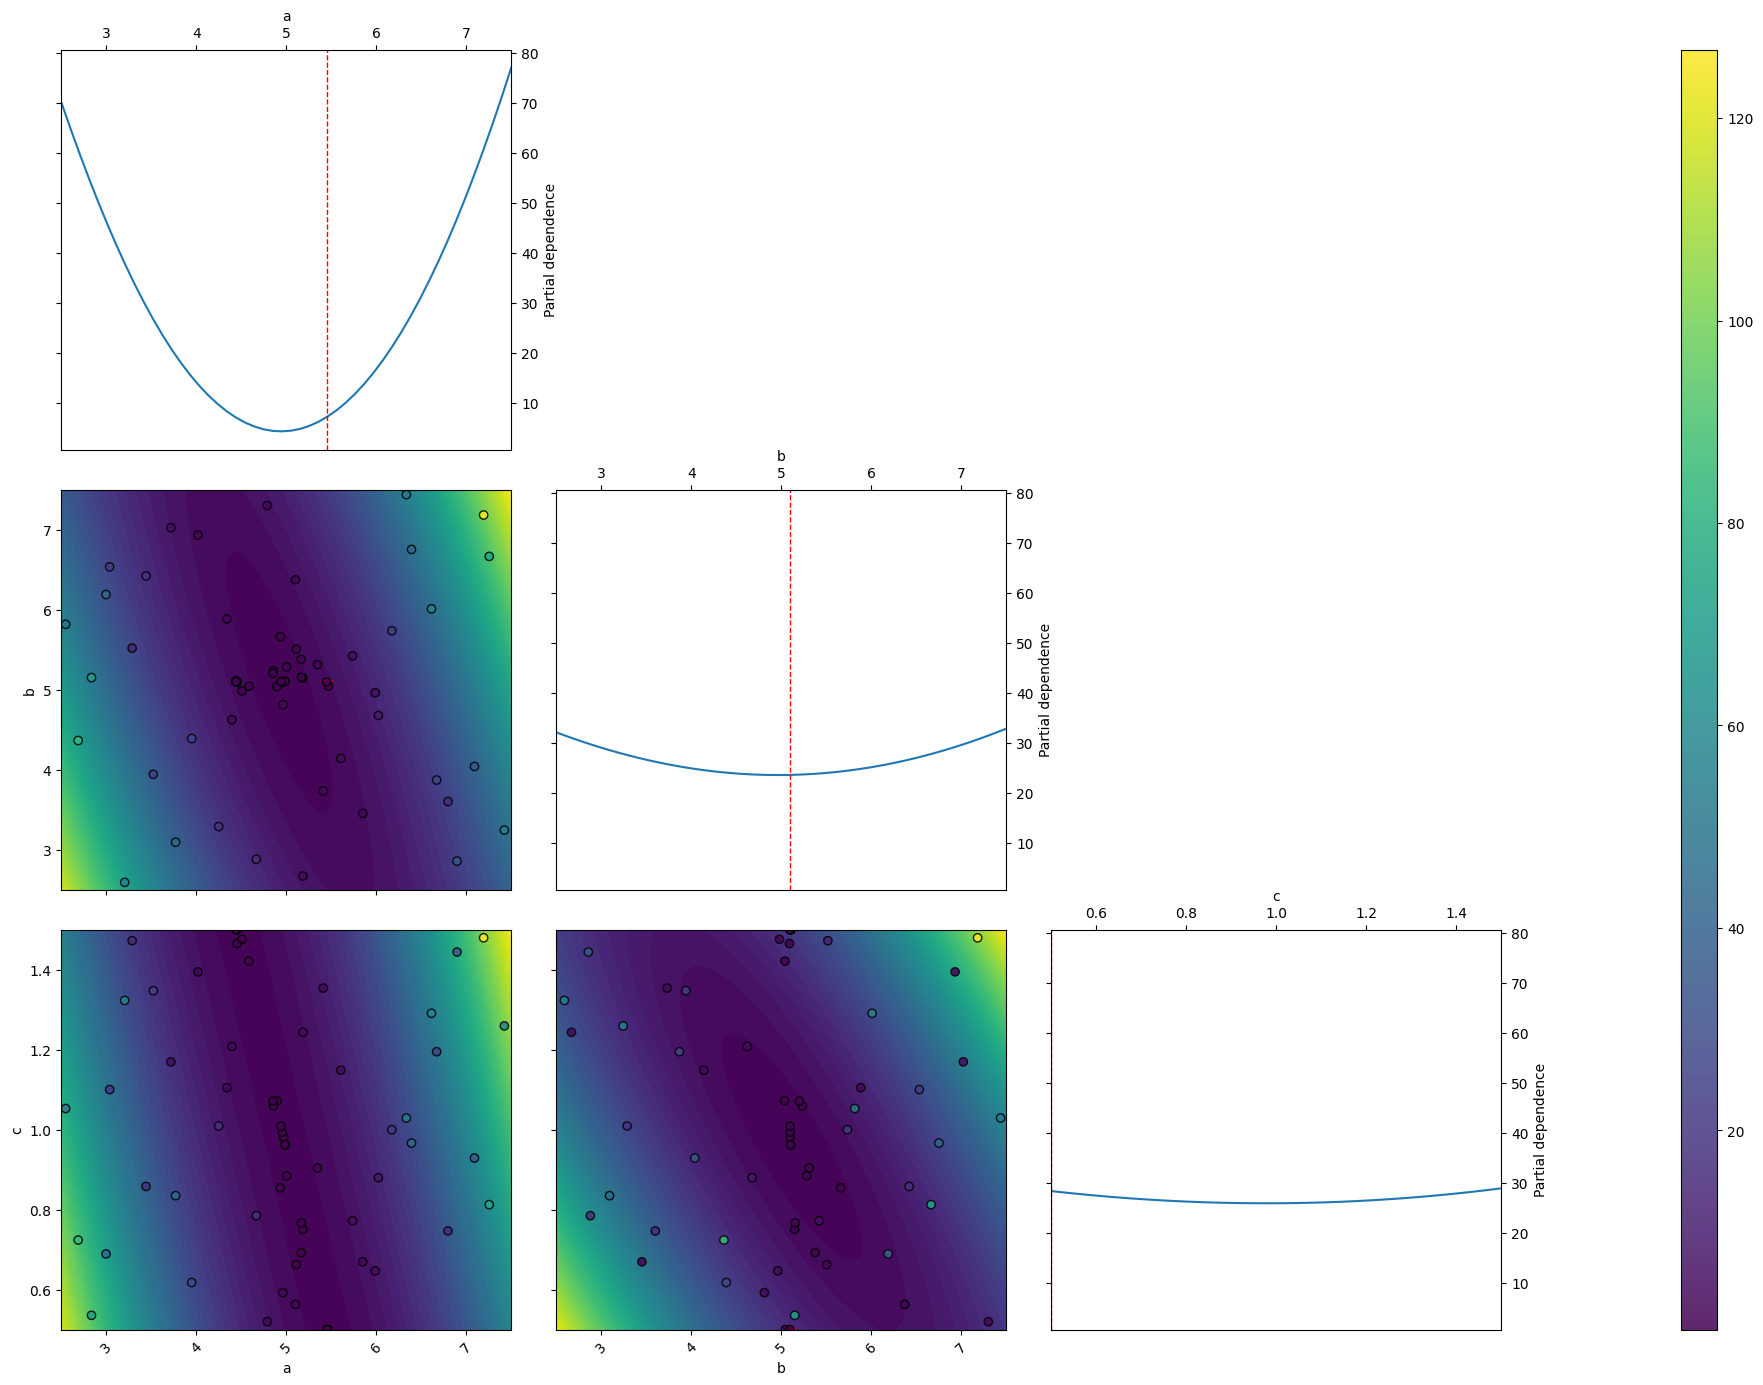

/home/larryl/Documents/vscodeprojs/boar/venv_boar/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/larryl/Documents/vscodeprojs/boar/venv_boar/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/larryl/Documents/vscodeprojs/boar/venv_boar/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find 

Minimum of surrogate function: [4.445742558678688, 5.094289059346368, 1.5] with function value 0.32676549738705063
Sampling for posterior distribution done in  0.6523885726928711 s


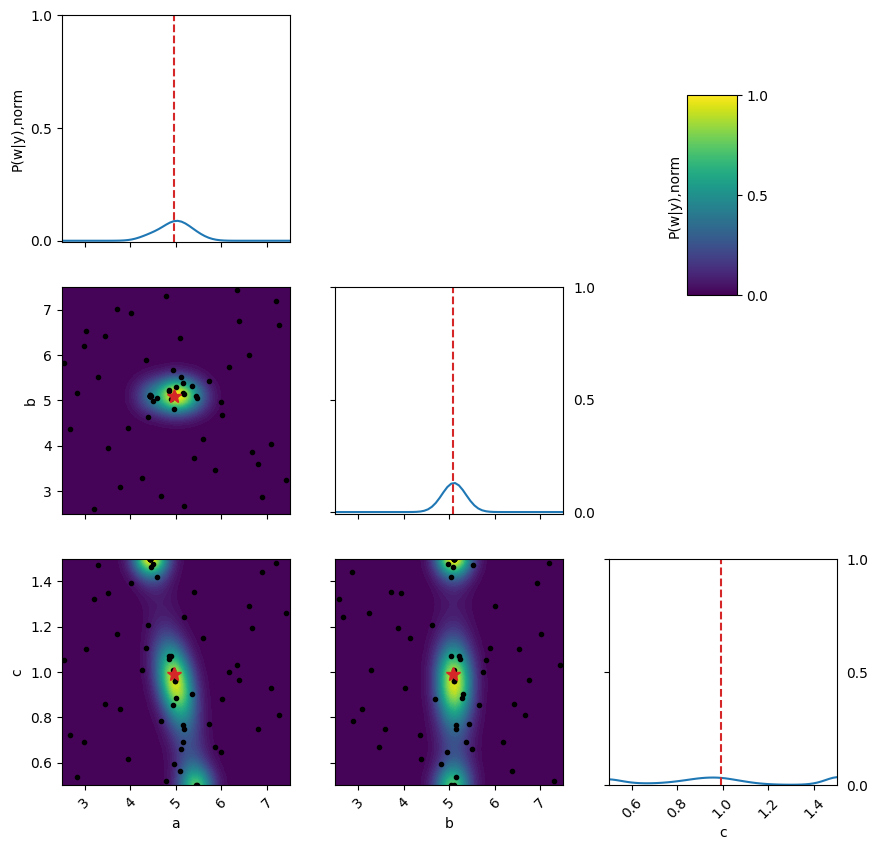

<Figure size 640x480 with 0 Axes>

In [7]:
# Then, try a Bayesian Optimizer

length_scales = [1 for _ in params]
length_scale_bounds = [(20, 100) for _ in params]


from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern, RBF
# Gaussian process with Matérn kernel as surrogate model


kernel = 0.3 * Matern(length_scale = length_scales, length_scale_bounds = length_scale_bounds, nu=2.5)
kernel = 0.3 * RBF(length_scale=length_scales, length_scale_bounds=length_scale_bounds)

gp = GaussianProcessRegressor(kernel=kernel)
gp = 'GP'

ii=0
mo.targets = [target]
mo.params = params
mo.warmstart = 'collect_init' if ii==0 else 'recall'
mo.warmstart = 'None'

truevals = {pp.name:pp.val for pp in params if pp.relRange!=0}

kwargs = {'check_improvement':'relax','max_loop_no_improvement':2,'xtol':1e-3,'ftol':1e-3}
kwargs_posterior = {'Nres':20,'gaussfilt':3,'logscale':False,'vmin':1e-100,'zoom':0,'min_prob':1e-40,
                    'clear_axis':False,'True_values':truevals,'show_points':True,'savefig':True,
                    'figname':'param_posterior'+str(ii),'figsize':(10,10)}
kwargs_plot_obj = {'zscale':'linear'}

r = mo.optimize_sko_parallel(n_jobs=4,n_yscale=20, n_BO=40, n_initial_points = 40,n_BO_warmstart=5,
                             n_jobs_init=None,loss='linear',threshold=1000,kwargs=kwargs,verbose=True,
                            base_estimator = gp,show_objective_func=True,kwargs_plot_obj=kwargs_plot_obj,show_posterior=True,
                            kwargs_posterior=kwargs_posterior)


In [8]:
print(r['r'].keys())
for p in params:
    print(p.val, '+-',p.std)

dict_keys(['x', 'fun', 'func_vals', 'x_iters', 'models', 'space', 'random_state', 'specs'])
5.4495055787979485 +- 0.3887010672811674
5.095464255035628 +- 0.2610173298083322
0.5 +- 0.28505282506088825


In [9]:
# plot the result from the sko
popt = r['popt']
a.val = r['popt'][0]
std2 = np.sqrt(np.diag(r['pcov']))

print('popt',r['popt'])
print('pcov',r['pcov'])
print('std',std2)

data = []
columns = [] # for output
for ii,L0 in enumerate(L): 
    pick = X[:,1]==L0
    xp = X[pick,0]
    yp = y[pick]
    plt.plot(xp,yp,'o',c='C'+str(ii))
    yf = yfit[pick]
    plt.plot(xp,yf,c='C'+str(ii))
    data = data + [xp,yp,yf]
    columns = columns + ['x','yexp','yfit']
plt.xlabel(xnames[0])
plt.ylabel(yname)

KeyError: 'pcov'

In [ ]:
# produce output excel file ( copied from Rong's notebook TRPL_simple, not adapted to work here)
ag = Agent()
param_dict = ag.get_param_dict(params) # get fitparameters (and fixed ones)
datax = np.array(data).T

#yfit = da.model_TRPL(X,params,state=0,const = 'kr')

# go in first sheet for first sheet
#data = np.hstack((texp.reshape(-1,1),yexp.reshape(-1,1),yfit.reshape(-1,1)))
# parameters go in second sheet
pout = [[f'{v:.3E}' if isinstance(v,float) else v for _,v in pp.items()] for pp in param_dict]

fn_xlsx = 'fits_testdata.xlsx'

with pd.ExcelWriter(fn_xlsx, mode='w') as writer:
    df = pd.DataFrame(datax,columns=columns)
    df.to_excel(writer, sheet_name = 'data') 
    df = pd.DataFrame(pout,columns=[k for k in param_dict[0].keys()])
    df.to_excel(writer, sheet_name = 'params') 